In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
test_csv = pd.read_csv("/opt/ml/dataset/test/test_data.csv")
# submission_csv = pd.read_csv("./prediction/submission.csv")
submission_csv = pd.read_csv("./prediction/RL_ST_NO_aug-punc-15000.csv")

sota_csv = pd.read_csv("./prediction/submission_jh.csv")

## 1. "예측 / SOTA 값" 비교 (태일)

In [10]:
sentences = test_csv["sentence"]
subject_entities, object_entities = test_csv["subject_entity"], test_csv["object_entity"] 
my_labels = submission_csv["pred_label"]
sota_labels = sota_csv["pred_label"]

In [11]:
i = -1
cnt = 0
# while i < 50: # 전체 텍스트: len(my_labels) - 1

while i < len(my_labels)-1:
    i += 1
    if my_labels[i] == sota_labels[i]:
        continue
    cnt += 1
    print(f"{cnt}: {sentences[i]}")
    print(f"sub:{eval(subject_entities[i])['word']}, obj:{eval(object_entities[i])['word']}")
    print(f"예측: {my_labels[i]}, sota: {sota_labels[i]}")
    print()
print(f"num of diff: {cnt} / {i}")

1: 소련군에서 그의 이름도 중국식의 진지첸으로 조선인으로서의 정체성도 희박했다.
sub:소련군, obj:진지첸
예측: no_relation, sota: org:top_members/employees

2: 실제로 틱톡의 ‘극한반전 챌린지’는 제2의 이병헌 감독을 꿈꾸는 영화 꿈나무들과 영상 꿈나무들 사이에서는 반드시 참여해야 하는 챌린지로 자리매김하고 있다.
sub:틱톡, obj:이병헌
예측: no_relation, sota: org:top_members/employees

3: 한편, 시는 3E 정책에 대한 아이디어가 있는 시민들은 누구나 정책을 제안 할 수 있도록 시청 홈페이지 ‘정책소통 1번가’를 통해 온-라인으로도 제안을 접수받고 있다.
sub:시, obj:3E
예측: no_relation, sota: org:product

4: A 씨는 대구 방문 6일째 질병관리본부에 전화했다.
sub:A, obj:대구
예측: per:place_of_residence, sota: no_relation

5: 동시에 울라슬로 2세는 게오르크와 결혼한 베아트릭스를 통해 크로아티아 지역의 반발 및 국경분쟁에 대처하려 했다.
sub:울라슬로 2세, obj:게오르크
예측: per:spouse, sota: no_relation

6: 이날 협약식에는 경남대 최호성 대외부총장과 거제 라마다 스위츠 거제호텔 정행철 대표이사를 비롯해 경남대 관광학부 선종갑, 박한수 교수 및 관계자가 참석한 가운데 진행됐다.
sub:라마다 스위츠 거제호텔, obj:경남대 관광학부
예측: no_relation, sota: org:member_of

7: 일찍이 이천(利川)의 율정(栗亭) 이관의(李寬義)의 문하에서 수학하였다.
sub:이관의, obj:이천
예측: no_relation, sota: per:origin

8: 엘사 분장을 하고 빅스 포스터를 보며 자신의 사진을 가리키는가 하면, 가슴 속에 숨겨 뒀던 당근을 꺼내 올라프에게 먹이는 듯한 제스처를 한다.
sub:엘사, obj:빅스
예측: no_

## csv파일로 뽑기(나연 추가)

In [21]:
from load_data import *
from train import *

test_csv = pd.read_csv("/opt/ml/dataset/test/test_data.csv")
test_csv = preprocessing_dataset(test_csv, marking_mode='normal')

res_df = pd.DataFrame()
res_df['sentence'] = test_csv['sentence']
res_df['sub'] = test_csv["subject_entity"]
res_df['obj'] = test_csv["object_entity"] 

res_df['sota'] = sota_csv["pred_label"]
res_df['my'] = submission_csv["pred_label"]

diff_df = res_df[res_df['sota'] != res_df['my']]  # sota와 다른 부분만
diff_df.to_csv("sub_eda.csv", index=False, encoding="utf-8-sig")  # 저장
diff_df
# res_df

,sentence,sub,obj,sota,my
9,소련군에서 그의 이름도 중국식의 진지첸으로 조선인으로서의 정체성도 희박했다.,소련군,진지첸,org:top_members/employees,no_relation
10,실제로 틱톡의 ‘극한반전 챌린지’는 제2의 이병헌 감독을 꿈꾸는 영화 꿈나무들과 영...,틱톡,이병헌,org:top_members/employees,no_relation
12,"한편, 시는 3E 정책에 대한 아이디어가 있는 시민들은 누구나 정책을 제안 할 수 ...",시,3E,org:product,no_relation
18,A 씨는 대구 방문 6일째 질병관리본부에 전화했다.,A,대구,no_relation,per:place_of_residence
20,동시에 울라슬로 2세는 게오르크와 결혼한 베아트릭스를 통해 크로아티아 지역의 반발 ...,울라슬로 2세,게오르크,no_relation,per:spouse
...,...,...,...,...,...
7731,"페리는 2011년 8월 28일 열린 MTV 비디오 뮤직 어워드에 참석해 ""Firew...",페리,Firework,per:product,no_relation
7732,"기장군은 우체국 집배원, 개인택시기사, 법인택시기사, 마을버스와 기장군버스 기사 등...",기장군,마스크,org:product,no_relation
7739,카를로스 살제도는 프랑스 아르카숑에서 1885년 4월 6일에 샤를 무아즈 레옹 살제...,샤를 무아즈 레옹 살제도,아르카숑,per:place_of_birth,per:alternate_names
7744,앞서 슬리피는 TS 직원들이 카니발을 사적으로 사용하는 바람에 소속사 연예인들은 S...,슬리피,연예인,per:title,org:top_members/employees


In [25]:
diff_df[diff_df['my'] == 'no_relation']
# diff_df['my']

,sentence,sub,obj,sota,my
9,소련군에서 그의 이름도 중국식의 진지첸으로 조선인으로서의 정체성도 희박했다.,소련군,진지첸,org:top_members/employees,no_relation
10,실제로 틱톡의 ‘극한반전 챌린지’는 제2의 이병헌 감독을 꿈꾸는 영화 꿈나무들과 영...,틱톡,이병헌,org:top_members/employees,no_relation
12,"한편, 시는 3E 정책에 대한 아이디어가 있는 시민들은 누구나 정책을 제안 할 수 ...",시,3E,org:product,no_relation
24,이날 협약식에는 경남대 최호성 대외부총장과 거제 라마다 스위츠 거제호텔 정행철 대표...,라마다 스위츠 거제호텔,경남대 관광학부,org:member_of,no_relation
32,일찍이 이천(利川)의 율정(栗亭) 이관의(李寬義)의 문하에서 수학하였다.,이관의,이천,per:origin,no_relation
...,...,...,...,...,...
7727,송진우는 김구의 충칭 임정의 통치권 주장을 미군정에서 도저히 받아들이지 않을 것이라...,김구,충칭,per:employee_of,no_relation
7728,백선엽과 간도특설대는 여기서 1945년 1월까지 항일 세력을 상대로 한 작전을 벌였다.,백선엽,간도특설대,per:employee_of,no_relation
7731,"페리는 2011년 8월 28일 열린 MTV 비디오 뮤직 어워드에 참석해 ""Firew...",페리,Firework,per:product,no_relation
7732,"기장군은 우체국 집배원, 개인택시기사, 법인택시기사, 마을버스와 기장군버스 기사 등...",기장군,마스크,org:product,no_relation


In [28]:
diff_df[diff_df['sota'] == 'no_relation']

,sentence,sub,obj,sota,my
18,A 씨는 대구 방문 6일째 질병관리본부에 전화했다.,A,대구,no_relation,per:place_of_residence
20,동시에 울라슬로 2세는 게오르크와 결혼한 베아트릭스를 통해 크로아티아 지역의 반발 ...,울라슬로 2세,게오르크,no_relation,per:spouse
59,초기에는 대부분의 경우 '탈퇴'라는 표현을 사용하였지만(결성 당시부터 나카자와 졸업...,ASAYAN,나카자와,no_relation,org:top_members/employees
71,"유민수 교수는 이번 수상을 통해 5만 달러의 연구비를 지원받게 되며, 시상식은 오는...",페이스북,유민수,no_relation,org:top_members/employees
75,"그는 “테크윈은 북미 B2B 매출이 고성장하는 가운데, 베트남 법인 안정화 등 원가...",테크윈,중국,no_relation,org:place_of_headquarters
...,...,...,...,...,...
7634,"BNK금융 부산은행과 경남은행이 신입행원 87명(부산은행 55명, 경남은행 32명)...",부산은행,신입행원,no_relation,org:members
7651,"화순군에 따르면, 정부는 태풍 피해 농가 손실 최소화를 위해 매입 규격을 신설해 농...",정부,화순군,no_relation,org:members
7667,"문 대통령은 구체적으로 ""인사에 대한 의견을 말해야 할 검찰총장이 '제3의 장소에 ...",문,검찰총장,no_relation,per:title
7687,쑨양은 지난 2012년 런던 올림픽에서 오랫동안 깨어지지 않았던 호주의 Grannt...,쑨양,호주,no_relation,per:origin


## 2. Check for Submission Distribution (찬국)
현재 자신의 모델이 잘 예측되었는지 시각적으로 확인하기 위한 코드입니다.  
해당 코드는 'no-relation으로 예측한 결과가 적으면, 그만큼 다른 label을 예측할 수 있기에 좋은 성능을 기대할 수 있을 것이다'라는 가설을 바탕으로 작성되었습니다.  
비교를 위해 리더보드에서 f1-score 70점을 달성한 재학님의 모델 예측 결과와 현재 자신의 submission의 분포를 비교할 수 있습니다.  
- 해당 코드는 distribution 확인을 위한 코드입니다. 기준 예측 결과는 추후 개선할 수 있습니다. 

In [13]:
# first_dataset
label_jh = sota_csv.groupby('pred_label').count().sort_values(by = 'id', ascending=False)
label_jh.reset_index(level=['pred_label'], inplace = True)
label_jh.drop('probs', axis=1, inplace=True)
label_jh.columns = ["pred_label", "count"]

In [14]:
# second_dataset
label = submission_csv.groupby('pred_label').count().sort_values(by = 'id', ascending=False)
label.reset_index(level=['pred_label'], inplace = True)
label.drop('probs', axis=1, inplace=True)
label.columns = ["pred_label", "count"]

## 2-1.Distribution

Text(0.5, 1.0, 'Submission Distribution')

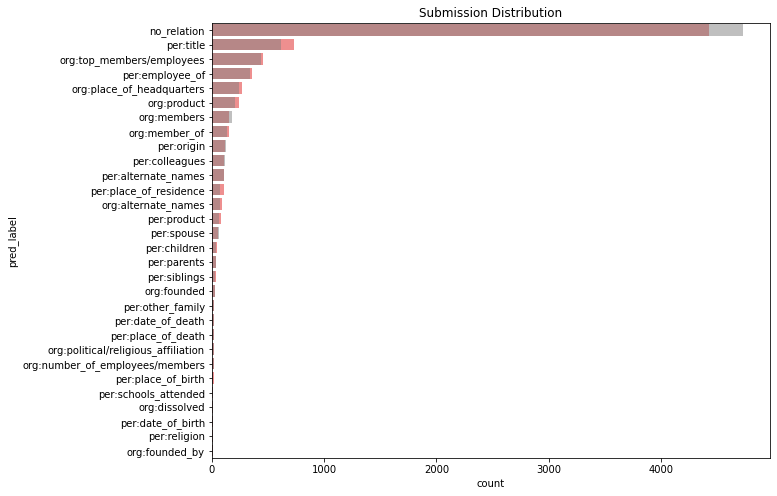

In [15]:
# 병렬적으로 확인하고 싶다면, subplot을 1,2로 주고 0ax 부분을 주석해제시키면 됩니다. 
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.barplot(y='pred_label', x='count', data=label_jh, # ax = axes[0],
              color='red',alpha=0.5 ) # pallete:

sns.barplot(y='pred_label', x='count', data=label, # ax = axes[1]
              color='gray',alpha=0.5 )
plt.title("Submission Distribution")

## 2-2.Difference

In [16]:
diff = label_jh['count'] - label['count']
diff_df =pd.DataFrame({"pred_label": label_jh['pred_label'], "diff":diff})

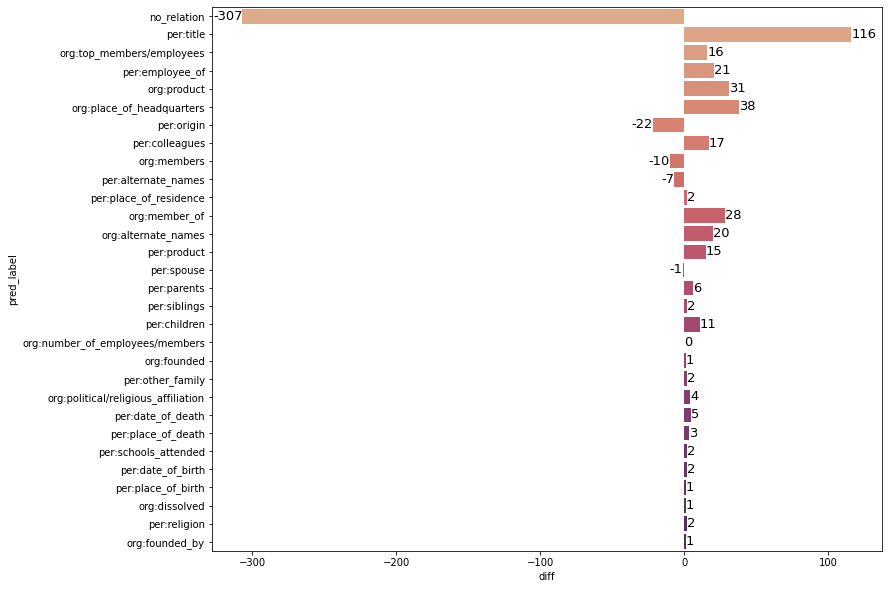

In [17]:
# 병렬적으로 확인하고 싶다면, subplot을 1,2로 주고 0ax 부분을 주석해제시키면 됩니다. 
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(y='pred_label', x='diff', data=diff_df, # ax = axes[0],
              palette='flare')

for i in ax.containers:
    ax.bar_label(i, fontsize=13)